# WIP: An Interactive Plotting Backend for `pyrolite`

In [4]:
import plotly
import numpy as np
import plotly.graph_objects as go
from pyrolite.data.Aitchison import load_kongite
import matplotlib.colors
import pyrolite.plot
from pyrolite.util.log import Handle

logger = Handle(__name__, level="DEBUG")
pyrolite_plot_BACKEND = "matplotlib"


def set_plotting_backend(backend=None):
    if backend is not None:
        if backend in ["matplotlib", "plotly"]:
            global pyrolite_plot_BACKEND
            logger.debug("Setting plotting backend to {}".format(backend))
            pyrolite_plot_BACKEND = backend
        else:
            raise NotImplementedError("Backend {} not available.")


class backend:
    def __init__(self, backend=None):
        self.start = pyrolite_plot_BACKEND
        self.backend = backend
        set_plotting_backend(self.backend)

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        # only reset when changed in the first place?
        if self.backend is not None:
            set_plotting_backend(self.start)


### Plotly Plotting Functions

* TODO: Make margins smaller
* Enable passing labels to markers
* Make plot variant for density plots

In [5]:
def to_plotly_color(color, alpha=1):
    # note that alpha isn't 255 scaled
    return "rgba" + str(
        tuple([int(i * 255) for i in matplotlib.colors.to_rgb(color)] + [alpha])
    )


def scatter(df, color="black", alpha=1, **kwargs):
    layout = dict(width=600, plot_bgcolor="white")
    fig = go.Figure()
    marker = dict(color=to_plotly_color(color, alpha=alpha))
    traces = [
        go.Scatter(
            x=df.iloc[:, 0],
            y=df.iloc[:, 1],
            mode="markers",
            marker=marker,
            showlegend=False,
            text=df.index.map("Sample {}".format),
        )
    ]
    fig.add_traces(traces)
    fig.update_layout(layout)
    fig.update_xaxes(linecolor="black", mirror=True, title=df.columns[0])  # todo: add this to layout
    fig.update_yaxes(linecolor="black", mirror=True, title=df.columns[1])  # todo: add this to layout
    return fig


def ternary(df, color="black", alpha=1, **kwargs):
    layout = dict(width=600, plot_bgcolor="white", ternary= {**{
        a: {
            "title": c,
            "showgrid": False,
            "linecolor": "black",
        }
        for a, c in zip(["aaxis", "baxis", "caxis"], df.columns)
    }, "bgcolor": "white"})
    layout.update(kwargs)
    marker = {"color": to_plotly_color(color, alpha=alpha)}
    data = {
        "mode": "markers",
        **dict(zip("abc", [df[c] for c in df.columns])),
        "text": df.index.values,
        "marker": marker,
    }
    fig = go.Figure(go.Scatterternary(data))

    fig.update_layout(
        layout
    )
    return fig


def spider(df, color="black", unity_line=True, alpha=1, text=None, **kwargs):
    layout = dict(width=600, plot_bgcolor="white")
    fig = go.Figure()
    line = dict(color=to_plotly_color(color, alpha=alpha))
    #hovertemplate = "%{text}<br><extra></extra>" if (text is not None) else None
    traces = [
        go.Scatter(
            x=df.columns,
            y=row,
            mode="lines+markers",
            line=line,
            showlegend=False,
            hoverinfo ='text',
            #hovertemplate =hovertemplate if (text is not None) else None,
            text = None if text is None else text[idx],
            name="Sample {}".format(idx) ,
        )
        for idx, row in df.iterrows()
    ]
    if unity_line:
        traces += [
            go.Scatter(
                x=df.columns,
                y=np.ones(df.columns.size),
                mode="lines",
                showlegend=False,
                name=None,
                line={"color": "black", "dash": "dot", "width": 0.5},
            )]
    fig.add_traces(traces)
    fig.update_layout(**layout)
    fig.update_yaxes(type="log", linecolor="black", mirror=True) # todo: add this to layout
    fig.update_xaxes(linecolor="black", mirror=True) # todo: add this to layout
    return fig


### Interface Switching

In [6]:
with backend("plotly"):
    with backend("matplotlib"):
        ...
    ...


2024-07-04 16:14:01,480 __main__ - DEBUG: Setting plotting backend to plotly
2024-07-04 16:14:01,481 __main__ - DEBUG: Setting plotting backend to matplotlib
2024-07-04 16:14:01,482 __main__ - DEBUG: Setting plotting backend to plotly
2024-07-04 16:14:01,483 __main__ - DEBUG: Setting plotting backend to matplotlib


In [7]:
logger.setLevel("INFO")

### Some Example Data

In [8]:
from pyrolite.util.synthetic import example_spider_data

ree_df = example_spider_data(
    noise_level=0.05,
    size=100,
    start="DMM_WH2005",
    norm_to="Chondrite_PON",
    offsets={"Eu": 0.2},
).pyrochem.REE
df = load_kongite()
df.head()

,A,B,C,D,E
Specimen,,,,,
K1,33.5,6.1,41.3,7.1,12.0
K2,47.6,14.9,16.1,14.8,6.6
K3,52.7,23.9,6.0,8.7,8.7
K4,44.5,24.2,10.7,11.9,8.7
K5,42.3,47.6,0.6,4.1,5.4


### Bivariate Scatter

<Axes: xlabel='B', ylabel='C'>

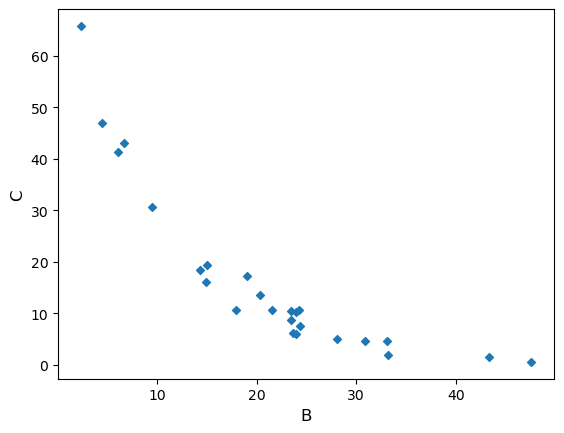

In [9]:
df.iloc[:, 1:3].pyroplot.scatter()

In [10]:
scatter(df.iloc[:, 1:3])

### Ternary

<TernaryAxes: tlabel='A', llabel='B', rlabel='C'>

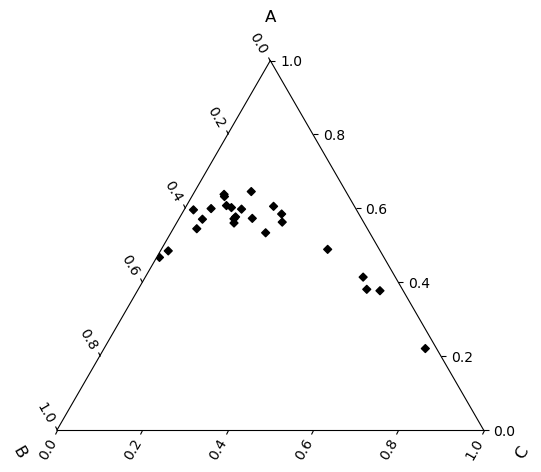

In [11]:
df.iloc[:, :3].pyroplot.scatter(color="k")


In [12]:
fig = ternary(df.iloc[:, :3], color="k")
# fig.write_html("ternary.html")

### Spider

<Axes: >

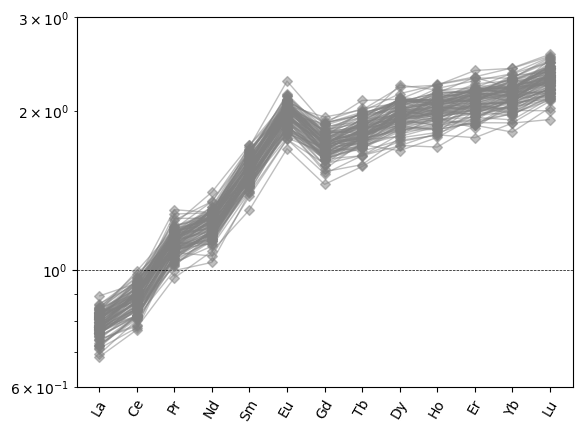

In [13]:
ree_df.pyroplot.spider(unity_line=True, color="0.5", alpha=0.5)


In [14]:
lambda_labels = ree_df.pyrochem.lambda_lnREE(anomalies=['Eu']).apply(lambda x: x.apply(lambda y: '{}: {:2.2f}'.format(x.name, y))).agg('<br>'.join, axis=1) # TODO: Could hover lambda labels

In [15]:
fig = spider(ree_df, unity_line=True, color="0.5", alpha=0.5, width=600, text=lambda_labels)
# fig.write_html("spider.html")